In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#read data from parquet file
#number of days from the beginning of the year to consider in the analysis
periodo = 365
USE_CUMSUM = True

common_filter = """
FROM datos_urgencia_consolidados.parquet
--where IdCausa in (7)
--where IdCausa in (2) 
--where IdCausa in (10) 
where IdCausa in (3,4,5,6,10,11)
and CodigoRegion is not null
--and GLOSATIPOESTABLECIMIENTO = 'Hospital'
--and CodigoRegion = 13
and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
--and year(strptime(fecha, '%d/%m/%Y')) in (2022,2023)
--group by CodigoRegion, dayofyear(strptime(fecha, '%d/%m/%Y'))
--group by CodigoRegion, fecha
group by CodigoDependencia, fecha
""" + """
having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
"""

#here CodigoDependencia indicates the "Servicio de Salud"
#to ignote the grouping by "region"  set "CodigoRegion" to a constant and remove it from the group by
df2 = duckdb.sql("""
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'Menores_1' as grupo_etario
    , sum(Menores_1) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    ,'De_1_a_4' as grupo_etario
    , sum(De_1_a_4) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_5_a_14' as grupo_etario
    , sum(De_5_a_14) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_15_a_64'  as grupo_etario
    , sum(De_15_a_64) as atenciones
"""+ common_filter + """
UNION
select year(strptime(fecha, '%d/%m/%Y')) as year
    , CodigoDependencia  as CodigoRegion
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
    , 'De_65_y_mas' as grupo_etario
    , sum(De_65_y_mas) as atenciones
"""+ common_filter + """
""").df()

df2 = df2.sort_values(by=['year','CodigoRegion','grupo_etario','nrodia']).reset_index(drop = True)

In [3]:
#the cumulative sum is taken on each of the classes, 
#is this case we group by "year", "CodigoRegion" and "grupo_etario"
#the result is a dataframe with the "nro_dia" in the columns, 
#in which the cumulative information of the demand, scaled from 0 to 1 is stored
groups = df2[["year","CodigoRegion","grupo_etario"]].drop_duplicates()
df_aux =df2.copy()
for (index, year, region, grupo_edad) in groups.itertuples():
    indicesToKeep = (df_aux.loc[:,'year'] == year) & (df_aux.loc[:,'CodigoRegion'] == region) & (df_aux.loc[:,'grupo_etario'] == grupo_edad)
    if sum(indicesToKeep)>0:
        if USE_CUMSUM:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'].cumsum()
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / max(df_aux.loc[indicesToKeep, 'atenciones'])
        else:
            df_aux.loc[indicesToKeep, 'atenciones'] = df_aux.loc[indicesToKeep, 'atenciones'] / sum(df_aux.loc[indicesToKeep, 'atenciones'])
df3 = df_aux.pivot(index=['year','CodigoRegion','grupo_etario'],columns= 'nrodia',values='atenciones').reset_index()

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Separating out the features
x_original = df3.loc[:, [k+1 for k in range(periodo)]].values

# Separating out the target
y = df3.loc[:,['CodigoRegion','grupo_etario']].values

#Standardizing the features
scaler = StandardScaler().fit(x_original)
x = scaler.transform(x_original)

pca = PCA(n_components=4)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4'])
finalDf = pd.concat([principalDf, df3[['CodigoRegion','grupo_etario']]], axis = 1)



In [5]:
# Import required libraries
import sklearn
import numpy as np
import matplotlib.pyplot as plt

# Dividing dataset into training and testing dataset and standarized the features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import SGDClassifier

In [10]:
#test for a good group in the classification
# here we test the different groupings to check if there 
# are others that make sense, since we test for binary classification 
#and we only have 5 classes it makes sense to consider the groupings
# (1), (2), (3), (4), (5), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5),(3,4),(3,5),(4,5)
#those can be presetned in an array and they describe all the possibilities for binary classification


# Declare the group we are trying to separate
maxiter = 1000
resultados= np.zeros([maxiter,5,5])
grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
for iter in range(maxiter):
    for group_indices in [[0], [1], [2], [3], [4], [0,1], [0,2], [0,3], [0,4], [1,2], [1,3], [1,4],[2,3],[2,4],[3,4]]:
    #for group_indices in [[0], [1], [2], [3], [4], [0,1], [0,2], [0,3], [0,4], [1,2], [1,3], [1,4],[2,3],[2,4],[3,4]]:
    #for group_indices in [[0,1]]:
        targets = []
        #for ind in set([0,1,2,3,4]) - set(group_indices):
        for ind in group_indices:
            if len(targets) == 0:
                targets = (finalDf[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
            else:
                targets = targets | (finalDf[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
    
        X, y = finalDf[["PC1","PC2","PC3"]].values , targets 
        
        # Split the dataset into a training and a testing set(20 percent)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
        #print ("\nTesting Dataset Shape:", X_train.shape, y_train.shape)
        
        # Standarize the features
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        # create the linear model SGDclassifier
        linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)
        
        # Train the classifier using fit() function
        linear_clf.fit(X_train, y_train)
    
        # Evaluate the result 
        #print(group_indices)
        #print([grupos_etarios[ind] for ind in group_indices])
        y_train_pred = linear_clf.predict(X_train)
        #print ("The Accuracy of our classifier is:", metrics.accuracy_score(y_train, y_train_pred)*100)
        if len(group_indices)==1:
            resultados[iter, group_indices[0],group_indices[0]] = metrics.accuracy_score(y_train, y_train_pred)
        else:
            resultados[iter, group_indices[0],group_indices[1]] = metrics.accuracy_score(y_train, y_train_pred)
            resultados[iter, group_indices[1],group_indices[0]] = resultados[iter,group_indices[0],group_indices[1]]
    #print(resultados[iter])
resultados.mean(0)




array([[0.69438793, 0.59142069, 0.60336552, 0.60043621, 0.65522931],
       [0.59142069, 0.73553276, 0.86971207, 0.54125   , 0.53515   ],
       [0.60336552, 0.86971207, 0.81716552, 0.53635517, 0.58135345],
       [0.60043621, 0.54125   , 0.53635517, 0.72373621, 0.8221069 ],
       [0.65522931, 0.53515   , 0.58135345, 0.8221069 , 0.84008793]])

In [11]:
pd.DataFrame(resultados.mean(0),columns=grupos_etarios, index = grupos_etarios)

,Menores_1,De_1_a_4,De_5_a_14,De_15_a_64,De_65_y_mas
Menores_1,0.694388,0.591421,0.603366,0.600436,0.655229
De_1_a_4,0.591421,0.735533,0.869712,0.541250,0.535150
De_5_a_14,0.603366,0.869712,0.817166,0.536355,0.581353
De_15_a_64,0.600436,0.541250,0.536355,0.723736,0.822107
De_65_y_mas,0.655229,0.535150,0.581353,0.822107,0.840088


In [8]:
#binary classification using the PCA, we compare the classification using only 2 PC and using 3 PC


# Declare the group we are trying to separate
grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]
group_indices = [1,2]
targets = []
for ind in group_indices:
    if len(targets) == 0:
        targets = (finalDf[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
    else:
        targets = targets | (finalDf[["grupo_etario"]]==grupos_etarios[ind]).values.ravel()
#targets = ((finalDf[["grupo_etario"]] == "Menores_1") | 
#          (finalDf[["grupo_etario"]] == "De_1_a_4")).values.ravel()
#targets = ((finalDf[["grupo_etario"]] == "De_1_a_4") | 
#          (finalDf[["grupo_etario"]] == "De_5_a_14")).values.ravel()
X, y = finalDf[["PC1","PC2","PC3"]].values , targets 
#X, y = finalDf[["PC1","PC2"]].values , targets 

# Split the dataset into a training and a testing set(20 percent)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
#print ("\nTesting Dataset Shape:", X_train.shape, y_train.shape)

# Standarize the features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# create the linear model SGDclassifier
from sklearn.linear_model import SGDClassifier
#linear_clf = SGDClassifier()
linear_clf = SGDClassifier(loss="hinge", alpha=0.000001, max_iter=1000)

# Train the classifier using fit() function
linear_clf.fit(X_train, y_train)

## Print the learned coeficients
#print ("\nThe coefficients of the linear boundary are:", linear_clf.coef_)
#print ("\nThe point of intersection of the line are:",linear_clf.intercept_)

# Evaluate the result

y_train_pred = linear_clf.predict(X_train)
print ("\nThe Accuracy of our classifier is:", metrics.accuracy_score(y_train, y_train_pred)*100)




The Accuracy of our classifier is: 89.48275862068965


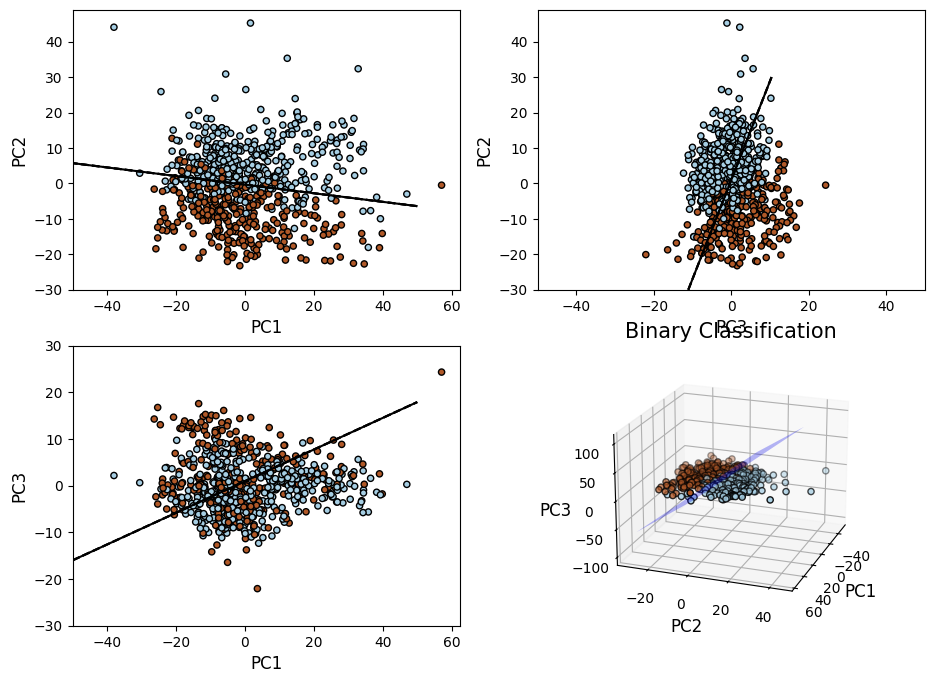

In [9]:
fig = plt.figure(figsize = (11,8))
ax = fig.add_subplot(2,2,1) 
#ax.set_title('PC1 vs PC2', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-50, 50, 10)
yy = np.linspace(-30, 30, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = linear_clf.decision_function([[x1, x2,0]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)


ax = fig.add_subplot(2,2,3) 
#ax.set_title('PC1 vs PC3', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC3', fontsize = 12)
# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-50, 50, 10)
yy = np.linspace(-30, 30, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = linear_clf.decision_function([[x1, 0,x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 0], X[:, 2], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)


ax = fig.add_subplot(2,2,2) 
#ax.set_title('PC2 vs PC3', fontsize = 15)
ax.set_xlabel('PC3', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-50, 50, 10)
yy = np.linspace(-30, 30, 10)

X1, X2 = np.meshgrid(xx, yy)
Z = np.empty(X1.shape)
for (i, j), val in np.ndenumerate(X1):
    x1 = val
    x2 = X2[i, j]
    p = linear_clf.decision_function([[0, x1,x2]])
    Z[i, j] = p[0]
levels = [-1.0, 0.0, 1.0]
linestyles = ["dashed", "solid", "dashed"]
colors = "k"
plt.contour(X1, X2, Z, levels, colors=colors, linestyles=linestyles)
plt.scatter(X[:, 2], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor="black", s=20)
#plt.axis("tight")
#plt.show()
ax = fig.add_subplot(2,2,4,projection='3d')

ax.set_title('Binary Classification', fontsize = 15)
ax.set_xlabel('PC1', fontsize = 12)
ax.set_ylabel('PC2', fontsize = 12)
ax.set_zlabel('PC3', fontsize = 12)
# plot the line, the points, and the nearest vectors to the plane
xx = np.linspace(-50, 50, 10)
yy = np.linspace(-30, 30, 10)
zz = np.linspace(-20, 20, 10)
X1, X2, X3 = np.meshgrid(xx, yy, zz)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.Paired, edgecolor="black")
X1, X2 = np.meshgrid(xx, yy)
ax.elev = 20
ax.azim = 20 # xy view
Zplane = -1/ linear_clf.coef_[0][2] * (linear_clf.intercept_[0]  + X1*linear_clf.coef_[0][0] + X2* linear_clf.coef_[0][1] )
ax.plot_surface(X1,X2,Zplane, color='blue',alpha=.3)
plt.show()
